## Import

In [1]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle
# You can also import other things ...

## Định nghĩa các hàm

**Hàm đọc bộ dữ liệu CIFAR-10**

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
def read_data(containing_dir, num_train_batchs):
    '''
    Read training and test data.
    
    Parameters
    ----------
    containing_dir : string
        The directory containing data files.
    num_train_batchs : int
        The number of data batchs used for training 
        (there are totally 5 data batchs; each one contains 10000 images).
    
    Returns
    -------
    (train_X, train_Y, test_X, test Y) : tuple
        train_X : numpy array, shape (num_train_batchs*10000, 32x32x3 + 1)
            The matrix of input vectors (each row corresponds to an input vector) of the training set;
            pixel values are normalized to [0, 1]; 
            the first column of this matrix is all ones (corresponding to x_0).
        train_Y : numpy array, shape (num_train_batchs*10000, 1)
            The vector of outputs of the training set.
        test_X : numpy array, shape (10000, 32x32x3 + 1)
            The matrix of input vectors of the test set (similar to train_X).
        test_Y : numpy array, shape (10000, 1)
            The vector of outputs of the test set.
    '''
    # Read training data
    train_X_batchs = []
    train_Y_batchs = []
    for batch_idx in range(num_train_batchs):
        batch = unpickle(containing_dir + '/data_batch_' + str(batch_idx + 1))
        train_X_batchs.append(batch['data'])
        train_Y_batchs.append(np.array(batch['labels']).reshape(-1, 1))
    train_X = np.vstack(train_X_batchs)
    train_X = train_X / 255. # Normalize to [0, 1]
    train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
    train_Y = np.vstack(train_Y_batchs)
    
    # Read test data
    batch = unpickle(containing_dir + '/test_batch')
    test_X = batch['data']
    test_X = test_X / 255. # Normalize to [0, 1]
    test_X = np.hstack([np.ones((len(test_X), 1)), test_X])
    test_Y = np.array(batch['labels']).reshape(-1, 1)
    
    return (train_X, train_Y, test_X, test_Y)

**Hàm tính output của Neural Net**

Ở đây, ta dùng hàm kích hoạt sigmoid ở các tầng ẩn, và hàm softmax ở tầng cuối.

In [3]:
def sigmoid(S):
    '''
    Computes sigmoid function for each element of array S.
    '''
    return 1 / (1 + np.exp(-S))
def softmax(S):
    '''
    Computes softmax function for each row of array S.
    '''
    A = np.exp(S)
    A /= A.sum(axis=1, keepdims=True)
    return A
def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    
    Parameters
    ----------
    Ws : list of numpy arrays
        Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer; it doesn't have W);
        W of layer l will have the shape of (d^(l-1)+1, d^(l)), where 
        d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1 and 
        d^(l) is the number of neurons (not count the +1 neuron) of layer l.
    X : numpy array, shape (N, d+1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    need_all_layer_outputs : bool
        If this var is true, we'll return a list of layer's-outputs; 
        otherwise, we'll return the final layer's output.
    
    Returns
    -------
    If `need_all_layer_outputs` is true, return
        A : numpy array, shape (N, K=10)
            The maxtrix of output vectors of final layer; each row is an output vector (containing 
            each class's probability given the corresponding input vector).
    Else, return
        As : list of numpy arrays
            As[l] is the matrix of output vectors of layer l; each row is an output vector (corresponding 
            to an input vector).
    '''    
    # TODO
    last_layer = X
    As=[]
    As.append(last_layer)
    for i in range(len(Ws)-1):
        W = Ws[i]
        next_layer = sigmoid(last_layer.dot(W))
        last_layer = np.concatenate( ( np.ones((next_layer.shape[0],1)) , next_layer),axis=1 )
        As.append(last_layer)
        
    output_layer = softmax(last_layer.dot(Ws[-1]))
    As.append(output_layer)
    
    if need_all_layer_outputs:
        return As      
    else:
        return As[-1]

**Hàm huấn luyện Neural Net**

Hàm `train_nnet` dưới đây đã được viết gần hết. Nhiệm vụ của bạn là:
- *Đọc hiểu code*. Một số ghi chú:
    - Trọng số nối từ tầng i đến tầng i+1 sẽ được khởi tạo ngẫu nhiên theo phân bố Gauss với mean bằng 0 và phương sai bằng *1/[(số nơ-ron tầng i) + 1]* (cộng 1 là tính thêm nơ-ron +1 ở tầng i). Tại sao lại dùng phương sai như vậy? Có thể mình sẽ nói cụ thể hơn ở trên lớp, nhưng ý ở đây là: xét một nơ-ron A ở tầng i+1, nếu số nơ-ron ở tầng i càng nhiều thì sẽ càng có nhiều trọng số đi vào nơ-ron A $\rightarrow$ giá trị trước kích hoạt của nơ-ron A sẽ càng dễ rơi vào hai cực của hàm sigmoid (dẫn đến học chậm) $\rightarrow$ cần giảm phương sai của phân bố Gauss lại khi số lượng nơ-ron ở tầng i tăng lên. 
    - Trong quá trình back-prop, ta không tính delta cho nơ-ron +1 (vì tính để làm gì?).
- *Bổ sung 3 dòng code*:
    - (1) Tính delta của tầng cuối, từ đó (2) tính gradient của W của tầng cuối (tính từ delta của tầng cuối và ouput của tầng kế cuối). Vì tầng cuối là tầng softmax (đã làm ở bài tập trước) nên bạn nên có đủ khả năng để viết được 2 dòng code này.
    - (3) Tính gradient của W của tầng l (tính từ delta của tầng l và ouput của tầng l-1): tương tự (2).

In [4]:
def train_nnet(X, Y, hid_layer_sizes, mb_size, learning_rate, max_epoch):
    '''
    Trains Neural Net on the dataset (X, Y).
    Cost function: mean negative log likelihood.
    Optimization algorithm: Stochastic Gradient Descent (SGD).
    
    Your code also needs to print out the cost and mean binary error on the training set after 
    each epoch (e.g., 'Epoch ..., cost ..., err ...%').
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N, 1)
        The vector of outputs.
    hid_layer_sizes : list
        The list of hidden layer sizes; e.g., hid_layer_sizes = [20, 10] means: the Net has 2 hidden 
        layers, the 1st one has 20 neurons, and the 2nd one has 10 neurons (not count the +1 neurons).
    mb_size : int
        Minibatch size of SGD.
    learning_rate : float
        Learning rate of SGD.
    max_epoch : int
        After this number of epochs, we'll terminate SGD.

    Returns
    -------
    (Ws, costs, errs) : tuple
        Ws : list of numpy arrays
            Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer; it doesn't have W);
            W of layer l will have the shape of (d^(l-1)+1, d^(l)), where 
            d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1 and 
            d^(l) is the number of neurons (not count the +1 neuron) of layer l.
        costs : list, len = max_epoch
            The list of costs after each epoch.
        errs : list, len = max_epoch
            The list of mean binary errors (on the training set) after each epoch.
    '''
    # Prepare for training
    K = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [K]
    np.random.seed(0) # This will fix the randomization; so, you and me will have the same results
    Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) / np.sqrt(layer_sizes[i] + 1) 
          for i in range(len(layer_sizes) - 1)] # Init Ws
    one_hot_Y = np.zeros((len(Y), K))
    one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
    costs = [] # To save costs during training
    errs = [] # To save mean binary errors during training
    N = len(X) # Num training examples
    rnd_idxs = range(N) # Random indexes    
    
    # Train
    for epoch in range(max_epoch):
        np.random.shuffle(rnd_idxs)
        for start_idx in range(0, N, mb_size):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            delta =As[-1]-mb_Y
            grad = As[-2].T.dot(delta)
            Ws[-1] -= learning_rate/len(mb_Y) * grad
            for i in range(2, len(Ws) + 1):
                delta = delta.dot(Ws[-i + 1].T[:, 1:]) * As[-i][:, 1:] * (1 - As[-i][:, 1:])
                grad = As[-i-1].T.dot(delta)
                Ws[-i] -= learning_rate/len(mb_Y)  * grad
        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        costs.append(cost)
        errs.append(err)
        print 'Epoch %d, cost %.3f, err %.3f%%' %(epoch, cost, err)
            
    return Ws, costs, errs

## Chạy

**1.** Đọc dữ liệu (bạn cần đặt thư mục chứa dữ liệu `cifar-10-batches-py` vào cùng thư mục chứa file notebook này)

In [5]:
num_train_batchs = 3 # It's enough to make my computer tired
train_X, train_Y, test_X, test_Y = read_data('cifar-10-batches-py', num_train_batchs)
print 'train_X.shape = %s, train_Y.shape = %s' %(train_X.shape, train_Y.shape)
print 'test_X.shape  = %s, test_Y.shape  = %s' %(test_X.shape, test_Y.shape)

train_X.shape = (30000, 3073), train_Y.shape = (30000, 1)
test_X.shape  = (10000, 3073), test_Y.shape  = (10000, 1)


**2.** Để thấy được sự ảnh hưởng của số lượng nơ-ron ẩn, ta sẽ lần lượt huấn luyện Neural Net với `hid_layer_sizes = [50]`, `[100]`, và `[200]` (cố định `mb_size = 32`, `learning_rate = 0.01`, `max_epoch = 200`)

In [6]:
W_0, costs_0, errs_0 = train_nnet(train_X, train_Y, [50], 32, 0.01, 200)

Epoch 0, cost 2.058, err 71.193%
Epoch 1, cost 1.955, err 68.027%
Epoch 2, cost 1.899, err 65.637%
Epoch 3, cost 1.868, err 65.903%
Epoch 4, cost 1.834, err 63.603%
Epoch 5, cost 1.819, err 63.923%
Epoch 6, cost 1.796, err 62.457%
Epoch 7, cost 1.779, err 62.110%
Epoch 8, cost 1.771, err 61.693%
Epoch 9, cost 1.757, err 61.413%
Epoch 10, cost 1.741, err 60.633%
Epoch 11, cost 1.733, err 60.643%
Epoch 12, cost 1.718, err 59.693%
Epoch 13, cost 1.711, err 59.637%
Epoch 14, cost 1.715, err 60.050%
Epoch 15, cost 1.691, err 58.993%
Epoch 16, cost 1.705, err 59.527%
Epoch 17, cost 1.679, err 58.890%
Epoch 18, cost 1.667, err 58.060%
Epoch 19, cost 1.662, err 58.117%
Epoch 20, cost 1.659, err 57.680%
Epoch 21, cost 1.638, err 56.930%
Epoch 22, cost 1.629, err 56.533%
Epoch 23, cost 1.628, err 56.957%
Epoch 24, cost 1.614, err 56.483%
Epoch 25, cost 1.612, err 56.473%
Epoch 26, cost 1.604, err 56.117%
Epoch 27, cost 1.600, err 56.260%
Epoch 28, cost 1.596, err 55.530%
Epoch 29, cost 1.585, er

Kết quả chạy của mình ở 3 epoch đầu (để bạn có thể check nhanh là đã cài đúng hay chưa):

`Epoch 0, cost 2.058, err 71.193%
Epoch 1, cost 1.955, err 68.027%
Epoch 2, cost 1.899, err 65.637%`

và ở epoch cuối (chỉ số epoch tính từ 0): 

`Epoch 199, cost 1.139, err 39.657%` 

In [7]:
W_1, costs_1, errs_1 = train_nnet(train_X, train_Y, [100], 32, 0.01, 200)

Epoch 0, cost 2.048, err 71.003%
Epoch 1, cost 1.941, err 66.537%
Epoch 2, cost 1.886, err 65.137%
Epoch 3, cost 1.856, err 64.937%
Epoch 4, cost 1.825, err 63.070%
Epoch 5, cost 1.807, err 62.647%
Epoch 6, cost 1.794, err 62.510%
Epoch 7, cost 1.783, err 62.320%
Epoch 8, cost 1.765, err 61.820%
Epoch 9, cost 1.759, err 61.517%
Epoch 10, cost 1.746, err 61.283%
Epoch 11, cost 1.733, err 60.147%
Epoch 12, cost 1.720, err 59.370%
Epoch 13, cost 1.716, err 59.997%
Epoch 14, cost 1.711, err 59.843%
Epoch 15, cost 1.690, err 58.557%
Epoch 16, cost 1.689, err 58.380%
Epoch 17, cost 1.679, err 59.233%
Epoch 18, cost 1.657, err 57.567%
Epoch 19, cost 1.650, err 57.280%
Epoch 20, cost 1.644, err 57.530%
Epoch 21, cost 1.642, err 56.933%
Epoch 22, cost 1.632, err 56.767%
Epoch 23, cost 1.625, err 56.490%
Epoch 24, cost 1.616, err 56.467%
Epoch 25, cost 1.616, err 56.413%
Epoch 26, cost 1.599, err 55.770%
Epoch 27, cost 1.590, err 55.780%
Epoch 28, cost 1.588, err 55.667%
Epoch 29, cost 1.602, er

Kết quả chạy của mình ở epoch cuối (chỉ số epoch tính từ 0): `Epoch 199, cost 1.036, err 35.687%`

In [8]:
W_2, costs_2, errs_2 = train_nnet(train_X, train_Y, [200], 32, 0.01, 200)

Epoch 0, cost 2.030, err 72.230%
Epoch 1, cost 1.931, err 68.573%
Epoch 2, cost 1.882, err 66.007%
Epoch 3, cost 1.849, err 64.307%
Epoch 4, cost 1.833, err 64.810%
Epoch 5, cost 1.812, err 63.287%
Epoch 6, cost 1.785, err 61.727%
Epoch 7, cost 1.777, err 61.900%
Epoch 8, cost 1.770, err 61.673%
Epoch 9, cost 1.764, err 60.757%
Epoch 10, cost 1.743, err 60.393%
Epoch 11, cost 1.752, err 62.213%
Epoch 12, cost 1.724, err 59.677%
Epoch 13, cost 1.721, err 59.883%
Epoch 14, cost 1.707, err 58.793%
Epoch 15, cost 1.703, err 58.823%
Epoch 16, cost 1.699, err 59.310%
Epoch 17, cost 1.688, err 58.680%
Epoch 18, cost 1.678, err 58.227%
Epoch 19, cost 1.665, err 57.763%
Epoch 20, cost 1.658, err 57.533%
Epoch 21, cost 1.650, err 57.127%
Epoch 22, cost 1.656, err 58.173%
Epoch 23, cost 1.651, err 57.927%
Epoch 24, cost 1.619, err 56.353%
Epoch 25, cost 1.610, err 55.910%
Epoch 26, cost 1.609, err 56.147%
Epoch 27, cost 1.603, err 55.820%
Epoch 28, cost 1.592, err 55.407%
Epoch 29, cost 1.578, er

Kết quả chạy của mình ở epoch cuối (chỉ số epoch tính từ 0): `Epoch 199, cost 0.952, err 32.057%`

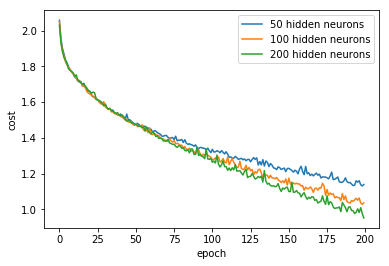

In [9]:
# Visualize results
epochs = np.arange(len(costs_0))
plt.plot(epochs, costs_0, label='50 hidden neurons')
plt.plot(epochs, costs_1, label='100 hidden neurons')
plt.plot(epochs, costs_2, label='200 hidden neurons')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend(loc='best')

Bình luận về đồ thị kết quả: TODO

Nhiều hidden neurons hơn thì mô hình fit dữ liệu nhanh hơn

Chạy nhiều epoch hơn thì mô hình nhiều neurons sẽ cho kết quả khác nhiều hơn so với mô hình ít neural

Hàm chi phí khi chạy bị biến thiên nhiêù ( có thể do chia tập trên thành batch? )


**3.** Tăng tốc SGD bằng momentum (*đây là phần làm thêm, không bắt buộc*)

Mã giả để cập nhật W của SGD-momentum như sau:

`V = momentum_param*V - learning_rate*grad
W = W + V`

với:

- `grad` là gradient trung bình trên minibatch
- `V` là mảng có cùng shape với `W`, ban đầu có thể khởi tạo cho `V` là một mảng toàn 0
- `momentum_param` là siêu tham số thuộc [0, 1)

Như có thể thấy, bước đi tại thời điểm t hiện tại của SGD-momentum không chỉ dùng gradient (trung bình trên minibatch) tại thời điểm t hiện tại như SGD, mà còn dùng thêm gradient ở các thời điểm trước đó (t-1, t-2, t-3, ...) với trọng số giảm dần (`momentum_param`, `momentum_param` bình phương, `momentum_param` lập phương, ...). Bằng cách xem xét thêm các gradient trong quá khứ, momentum giúp tăng tốc SGD: những hướng đi nhất quán sẽ được tăng cường, những hướng đi không nhất quán sẽ được giảm bớt. 

In [15]:
def train_nnet_1(X, Y, hid_layer_sizes, mb_size, learning_rate, max_epoch, momentum_param):
    '''
    Trains Neural Net on the dataset (X, Y).
    Cost function: mean negative log likelihood.
    Optimization algorithm: Stochastic Gradient Descent (SGD) + momentum.
    
    Your code also needs to print out the cost and mean binary error on the training set after 
    each epoch (e.g., 'Epoch ..., cost ..., err ...%').
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N, 1)
        The vector of outputs.
    hid_layer_sizes : list
        The list of hidden layer sizes; e.g., hid_layer_sizes = [20, 10] means: the Net has 2 hidden 
        layers, the 1st one has 20 neurons, and the 2nd one has 10 neurons (not count the +1 neurons).
    mb_size : int
        Minibatch size of SGD.
    learning_rate : float
        Learning rate of SGD.
    max_epoch : int
        After this number of epochs, we'll terminate SGD.
    momentum_param : float, in [0, 1)
        Momentum parameter; it determines how quickly the contributions of previous gradients decay.
    Returns
    -------
    (Ws, costs, errs) : tuple
        Ws : list of numpy arrays
            Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer; it doesn't have W);
            W of layer l will have the shape of (d^(l-1)+1, d^(l)), where 
            d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1 and 
            d^(l) is the number of neurons (not count the +1 neuron) of layer l.
        costs : list, len = max_epoch
            The list of costs after each epoch.
        errs : list, len = max_epoch
            The list of mean binary errors (on the training set) after each epoch.
    '''
    # TODO
    
    # Prepare for training
    K = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [K]
    np.random.seed(0) # This will fix the randomization; so, you and me will have the same results
    Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) / np.sqrt(layer_sizes[i] + 1) 
          for i in range(len(layer_sizes) - 1)] # Init Ws
    one_hot_Y = np.zeros((len(Y), K))
    one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
    costs = [] # To save costs during training
    errs = [] # To save mean binary errors during training
    N = len(X) # Num training examples
    rnd_idxs = range(N) # Random indexes    
    
    V = np.zeros_like(Ws)

    # Train
    for epoch in range(max_epoch):
        np.random.shuffle(rnd_idxs)
        for start_idx in range(0, N, mb_size):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            
            delta =As[-1]-mb_Y
            grad = As[-2].T.dot(delta)
            
            V[-1] = momentum_param * V[-1] - learning_rate/len(mb_Y)*grad
            Ws[-1] = Ws[-1] + V[-1]
            for i in range(2, len(Ws) + 1):
                delta = delta.dot(Ws[-i + 1].T[:, 1:]) * As[-i][:, 1:] * (1 - As[-i][:, 1:])
                grad = As[-i-1].T.dot(delta)
                
                V[-i] = momentum_param*V[-i] - learning_rate/len(mb_Y)*grad
                Ws[-i] = Ws[-i] + V[-i]
        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        costs.append(cost)
        errs.append(err)
        print 'Epoch %d, cost %.3f, err %.3f%%' %(epoch, cost, err)
            
    return Ws, costs, errs
    

In [16]:
W_3, costs_3, errs_3 = train_nnet_1(train_X, train_Y, [50], 32, 0.01, 200, momentum_param=0.5)

Epoch 0, cost 1.962, err 68.487%
Epoch 1, cost 1.864, err 65.047%
Epoch 2, cost 1.823, err 63.960%
Epoch 3, cost 1.799, err 63.580%
Epoch 4, cost 1.762, err 61.477%
Epoch 5, cost 1.747, err 61.760%
Epoch 6, cost 1.717, err 59.843%
Epoch 7, cost 1.702, err 59.670%
Epoch 8, cost 1.690, err 59.073%
Epoch 9, cost 1.674, err 58.507%
Epoch 10, cost 1.649, err 57.443%
Epoch 11, cost 1.643, err 57.973%
Epoch 12, cost 1.614, err 56.107%
Epoch 13, cost 1.605, err 56.243%
Epoch 14, cost 1.607, err 56.180%
Epoch 15, cost 1.590, err 55.577%
Epoch 16, cost 1.608, err 56.563%
Epoch 17, cost 1.571, err 55.273%
Epoch 18, cost 1.555, err 54.567%
Epoch 19, cost 1.551, err 54.733%
Epoch 20, cost 1.545, err 54.383%
Epoch 21, cost 1.519, err 53.210%
Epoch 22, cost 1.508, err 52.637%
Epoch 23, cost 1.507, err 53.027%
Epoch 24, cost 1.498, err 53.017%
Epoch 25, cost 1.505, err 53.360%
Epoch 26, cost 1.480, err 52.060%
Epoch 27, cost 1.475, err 52.093%
Epoch 28, cost 1.472, err 51.363%
Epoch 29, cost 1.462, er

Kết quả chạy của mình ở epoch cuối (chỉ số epoch tính từ 0): `Epoch 199, cost 0.949, err 32.840%`

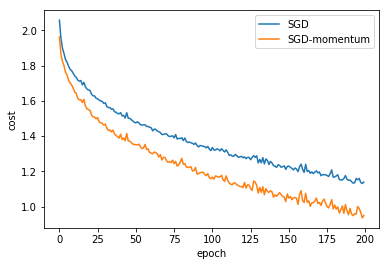

In [17]:
# Visualize SGD and SGD-momentum
epochs = np.arange(len(costs_0))
plt.plot(epochs, costs_0, label='SGD')
plt.plot(epochs, costs_3, label='SGD-momentum')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend(loc='best')

momentum tốc độ fit mô hình với dữ liệu nhanh hơn.